**Programação Linear**

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog

# Leitura dos dados
geracao = pd.read_excel('DadosDeEntrada.xlsx').values

# Parâmetros iniciais
G_Solar = np.zeros(288)
Radiacao = np.array(geracao[18:306, 7])
Temperatura = np.array(geracao[18:306, 6])
Vento = np.array(geracao[18:306, 4])

# Cálculo da geração solar
for i in range(len(Radiacao)):
    G_Solar[i] = 0.97 * (Radiacao[i]) / 1000 * (1 + 0.005 * ((Temperatura[i]) - 25))

# Parâmetros eólicos
V_min = 3
V_nominal = 12
V_max = 25
n_WT = 1
eta_WT = 0.9
P_R_WT = 1
u_cut_in = 3
u_rated = 12
u_cut_off = 25

# Potência gerada pelo vento
P_WT = np.zeros(len(Vento))
for i, u in enumerate(Vento):
    if u < u_cut_in:
        P_WT[i] = 0
    elif u_cut_in <= u <= u_rated:
        P_WT[i] = n_WT * eta_WT * P_R_WT * ((u**2 - u_cut_in**2) / (u_rated**2 - u_cut_in**2))
    elif u_rated < u < u_cut_off:
        P_WT[i] = n_WT * eta_WT * P_R_WT
    else:
        P_WT[i] = 0

# Parâmetros gerais
potenciadosistema = 25000
potenciaEolicamaxima_values = P_WT * potenciadosistema
potenciasolarmaxima_values = G_Solar * potenciadosistema
Carga_Residencial = geracao[18:306, 12] * 30000

precoH2 = 14.3
precoeolica = 0.1712
precosolar = 0.17566
precobateria = 0.01
tanque_hidrogenio_max = 20
nivel_tanque = tanque_hidrogenio_max
consumo_kg_h2 = 0.2
eficiencia_eletrolisador = 0.75
consumo_kW_h2 = -53571*eficiencia_eletrolisador + 92643
potencia_maxima_eletrolisador = 40000
niveis_eletrolisador = 6

# Possibilidades do eletrólise
for n in range(1, niveis_eletrolisador + 1):
    if n==1:
        possibilidades_eletrolisador = [0]
    else:
        possibilidades_eletrolisador = [0] + [i * potencia_maxima_eletrolisador / niveis_eletrolisador for i in range(1, niveis_eletrolisador + 1)]


# Inicialização
pbat = 30000
potenciaBateria_max = pbat
potenciaH2maxima = 30000
potenciaBateria_min = 3000
status_bateria = np.zeros(len(Carga_Residencial))
status_tanque = np.zeros(len(Carga_Residencial))

 # Inicializando listas para armazenar os resultados
PotenciaSolar = []
PotenciaEolica = []
CustoTotal = []
PotenciaH2 = []
PotenciaBateria = []

for i in range(len(potenciasolarmaxima_values)):
    status_bateria[i] = potenciaBateria_max
    status_tanque[i] = nivel_tanque
    potenciasolarmaxima = potenciasolarmaxima_values[i]
    potenciaEolicamaxima = potenciaEolicamaxima_values[i]
    
    if potenciaBateria_max > 3000:
        # Problema de otimização
        c = [precosolar, precoeolica , precoH2, precobateria ]
        A_eq = [[1, 1, 1, 1]]
        b_eq = [Carga_Residencial[i]]
        bounds = [
            (0, potenciasolarmaxima),
            (0, potenciaEolicamaxima),
            (0, potenciaH2maxima),
            (potenciaBateria_min, potenciaBateria_max),
        ]
        # Resolvendo o problema de otimização
        result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        
    else:
        # Problema de otimização
        c = [precosolar, precoeolica , precoH2, 0 ]
        A_eq = [[1, 1, 1,1]]
        b_eq = [Carga_Residencial[i]]
        bounds = [
            (0, potenciasolarmaxima),
            (0, potenciaEolicamaxima),
            (0, potenciaH2maxima),
            (0,0),
                ]
        # Resolvendo o problema d
        result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    PotenciaBateria.append(result.x[3])
    PotenciaSolar.append(result.x[0])  
    PotenciaEolica.append(result.x[1])  
    CustoTotal.append(result.fun)  # Adicionando o valor da função objetivo
    PotenciaH2.append(result.x[2])  
       

    possivel_carga_bateria = potenciasolarmaxima + potenciaEolicamaxima - Carga_Residencial[i]
    possivel_carga_H2 = potenciasolarmaxima + potenciaEolicamaxima - Carga_Residencial[i] - possivel_carga_bateria
    if possivel_carga_bateria < 0:
        possivel_carga_bateria = 0
    if possivel_carga_H2 < 0:
        possivel_carga_H2 = 0
    if possivel_carga_bateria > pbat - potenciaBateria_max:
        possivel_carga_bateria = pbat - potenciaBateria_max #igual ao valor da diferenca entre a capacidade maxima e a capacidade atual

    if nivel_tanque >= tanque_hidrogenio_max:
        possivel_carga_H2 = 0
    else:
        for n in range(2, niveis_eletrolisador + 2):
            if possivel_carga_H2 < possibilidades_eletrolisador[n - 1]:
                possivel_carga_H2 = possibilidades_eletrolisador[n - 2]
            if n == (niveis_eletrolisador + 1) and possivel_carga_H2 >= possibilidades_eletrolisador[n - 1]:
                possivel_carga_H2 = possibilidades_eletrolisador[n - 1]
    if tanque_hidrogenio_max - nivel_tanque < possivel_carga_H2/consumo_kW_h2:
        possivel_carga_H2 = ((tanque_hidrogenio_max - nivel_tanque)*consumo_kW_h2)

       
    if result.success:
        x = result.x
        potenciaBateria_max = potenciaBateria_max - x[3] + possivel_carga_bateria
        #potenciaBateria_max1 = max(potenciaBateria_max, 3000)
        nivel_tanque = (nivel_tanque - (x[2] / 1000) * consumo_kg_h2 + (possivel_carga_H2 /consumo_kW_h2))
    if potenciaBateria_max < 3000:
        potenciaBateria_max = 3000

    
        
PotenciaTotal = []           
for i in range(len(PotenciaEolica)):
    PotenciaTotal.append(potenciasolarmaxima_values[i] + potenciaEolicamaxima_values[i])

          # Calculando o custo total do dia
Custo_dia = sum(CustoTotal)/1000
status_bateria = status_bateria*100/pbat
status_tanque = status_tanque*100/tanque_hidrogenio_max
print("Otimização concluída, custo total.", Custo_dia)


PermissionError: [Errno 13] Permission denied: 'DadosDeEntrada.xlsx'

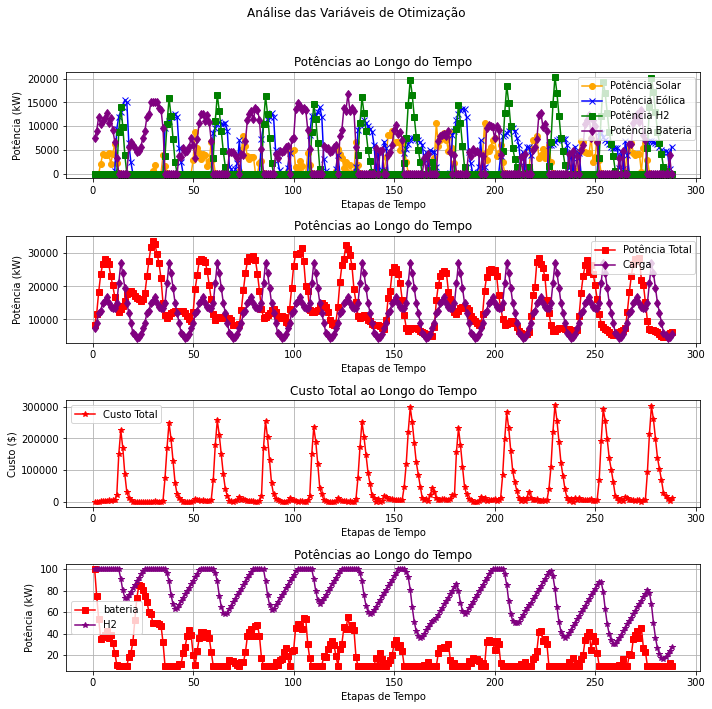

In [31]:
import matplotlib.pyplot as plt

# Criando os índices das etapas de tempo
timesteps = range(1, len(PotenciaSolar) + 1)

# Configurar os subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
fig.suptitle('Análise das Variáveis de Otimização')

# Plot 1: Potências (Solar, Eólica, H2 e Bateria)
axs[0].plot(timesteps, PotenciaSolar, label="Potência Solar", marker="o", color="orange")
axs[0].plot(timesteps, PotenciaEolica, label="Potência Eólica", marker="x", color="blue")
axs[0].plot(timesteps, PotenciaH2, label="Potência H2", marker="s", color="green")
axs[0].plot(timesteps, PotenciaBateria, label="Potência Bateria", marker="d", color="purple")
axs[0].set_title("Potências ao Longo do Tempo")
axs[0].set_xlabel("Etapas de Tempo")
axs[0].set_ylabel("Potência (kW)")
axs[0].legend()
axs[0].grid()

# Plot 2: Custo Total
axs[2].plot(timesteps, CustoTotal, label="Custo Total", marker="*", color="red")
axs[2].set_title("Custo Total ao Longo do Tempo")
axs[2].set_xlabel("Etapas de Tempo")
axs[2].set_ylabel("Custo ($)")
axs[2].legend()
axs[2].grid()

axs[1].plot(timesteps, PotenciaTotal, label="Potência Total", marker="s", color="red")
axs[1].plot(timesteps, Carga_Residencial, label="Carga", marker="d", color="purple")
axs[1].set_title("Potências ao Longo do Tempo")
axs[1].set_xlabel("Etapas de Tempo")
axs[1].set_ylabel("Potência (kW)")
axs[1].legend()
axs[1].grid()

axs[3].plot(timesteps, status_bateria, label="bateria", marker="s", color="red")
axs[3].plot(timesteps, status_tanque, label="H2", marker="*", color="purple")
axs[3].set_title("Potências ao Longo do Tempo")
axs[3].set_xlabel("Etapas de Tempo")
axs[3].set_ylabel("Potência (kW)")
axs[3].legend()
axs[3].grid()
# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [10]:
x= [[1],[2],[3]]
print(type(x))



print(x)

[[1], [2], [3]]


In [33]:
print(x)

[   0. 5700.    0.    0.]
